## Sentiment Analysis of English Texts

### Approach: Support Vector Machine(SVM)

#### Importing required libraries

In [2]:
#General libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer

# Downloading necessary datasets from NLTK
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

# Machine Learning libraries
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srays/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\srays/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\srays/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\srays/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


#### Loading the dataset

In [6]:
df = pd.read_csv("IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


#### Exploratory Data Analysis(EDA)

In [11]:
# Shape of the dataset
print(f"This dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

# Statistical figures about the dataset
print("Statistical figures: ")
print(df.describe())

# Count and types of sentiments
print(f"There are {df['sentiment'].nunique()} sentiments in this dataset and they are: ")
for i in range(df['sentiment'].nunique()):
    print(f"{i+1}. {df['sentiment'].unique()[i]}")

This dataset has 50000 rows and 2 columns.
Statistical figures: 
                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000
There are 2 sentiments in this dataset and they are: 
1. positive
2. negative


#### Visualizing the dataset

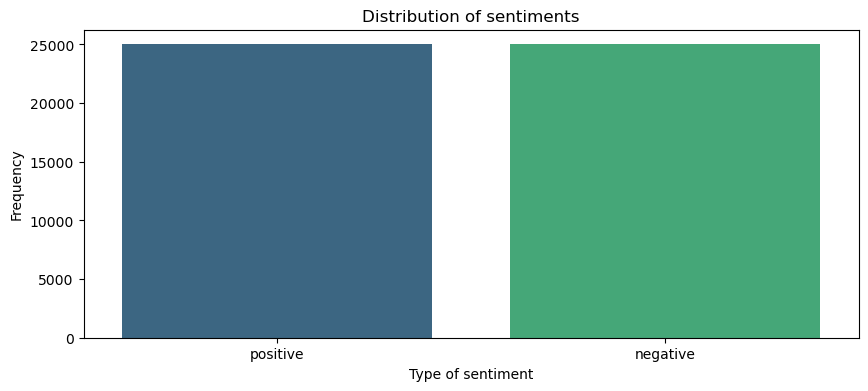

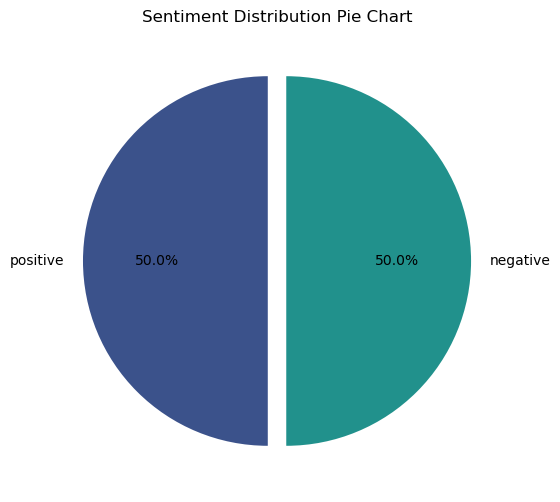

In [12]:
# Frequency plot
plt.figure(figsize = (10, 4))
sns.countplot(data = df, x = df['sentiment'], palette = 'viridis')
plt.title('Distribution of sentiments')
plt.xlabel('Type of sentiment')
plt.ylabel('Frequency')
plt.show()

# Pie chart
plt.figure(figsize = (6, 6))
df['sentiment'].value_counts().plot.pie(autopct = '%1.1f%%', colors = sns.color_palette('viridis', 3), startangle = 90, explode = [0.05]*2)
plt.title('Sentiment Distribution Pie Chart')
plt.ylabel('')
plt.show()

#### Text Preprocessing

In [ ]:
# Importing some more libraries
import spacy
import unicodedata
from bs4 import BeautifulSoup

##### Data Cleaning

In [ ]:
def clean_data(text):    
    # Convert to lowercase
    text = text.lower()
    
    # Tie "not" with the next word to retain the negative sentiment
    text = re.sub(r'\bnot\b \b\w+\b', lambda x: x.group().replace(' ', '_'), text)

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove user @ references and '#' from hashtags
    text = re.sub(r'\@\w+|\#','', text)
    
    # Remove special characters, numbers, and punctuations
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    
    # Remove single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # Remove multiple spaces
    text = re.sub(r'\s+', ' ', text)
       
    #Remove HTML tags
    text = BeautifulSoup(text, 'lxml').get_text()
    
    #Remove any emails
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)
    
    #remove any mentions
    text=re.sub(r'@\w+', '', text).strip()
    
    #remove repeated characters
    text=re.sub(r'(.)\1+', r'\1\1', text)
    
    return text.strip()

# Apply cleaning and fix contractions
df['text'] = df['review'].apply(lambda x: contractions.fix(x))
df['clean_text'] = df['text'].apply(clean_data)

# Display cleaned text
df[['review','text', 'clean_text']].head()

,review,text,clean_text
0,One of the other reviewers has mentioned that ...,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,A wonderful little production. <br /><br />The...,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,I thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...
3,Basically there's a family where a little boy ...,Basically there is a family where a little boy...,basically there is family where little boy jak...
4,"Petter Mattei's ""Love in the Time of Money"" is...","Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love in the time of money is vis...


##### Tokenization, Lemmatization and Removing Stopwords

In [15]:
# Initialize the lemmatizer object
wnl = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Helper function to map POS tag to wordnet POS
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun
    
# Lemmatization function
def lemmatize_data(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words]
    pos_tagged = nltk.pos_tag(filtered_words)
    lemmatized_words = [wnl.lemmatize(word, get_wordnet_pos(pos)) for word, pos in pos_tagged]
    return " ".join(lemmatized_words)

# Apply lemmatization to the 'clean_text' column
df['lemmatized_text'] = df['clean_text'].apply(lemmatize_data)

df[['review', 'clean_text', 'lemmatized_text', 'sentiment']].head()

,review,clean_text,lemmatized_text,sentiment
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...,one reviewer mention watch oz episode hook rig...,positive
1,A wonderful little production. <br /><br />The...,a wonderful little production br br the filmin...,wonderful little production br br film techniq...,positive
2,I thought this was a wonderful way to spend ti...,i thought this was wonderful way to spend time...,think wonderful way spend time hot summer week...,positive
3,Basically there's a family where a little boy ...,basically there is family where little boy jak...,basically family little boy jake think zombie ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love in the time of money is vis...,petter mattei love time money visually stunnin...,positive


#### Vectorization (using TF-IDF)

In [ ]:
y = df['sentiment'].map({'negative':0, 'positive':1})

# Define the input feature
X = df['lemmatized_text']

# Initialize the TF-IDF vectorizer
vec = TfidfVectorizer(ngram_range = (1, 5), max_df = 0.95, min_df = 2, max_features = 10000)

# Convert the lemmatized text to a TF-IDF matrix
X = vec.fit_transform(X)

# Saving the vectorizer in the pickle file

In [10]:
import pickle
pickle.dump(vec,open('vectorizer1.pkl','wb')) 

#### Initializing and training the model

In [17]:
from scipy.stats import uniform 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn import svm

#### We first fitted 20% of the data for fast tuning so in that also the graph looks same (attached below)

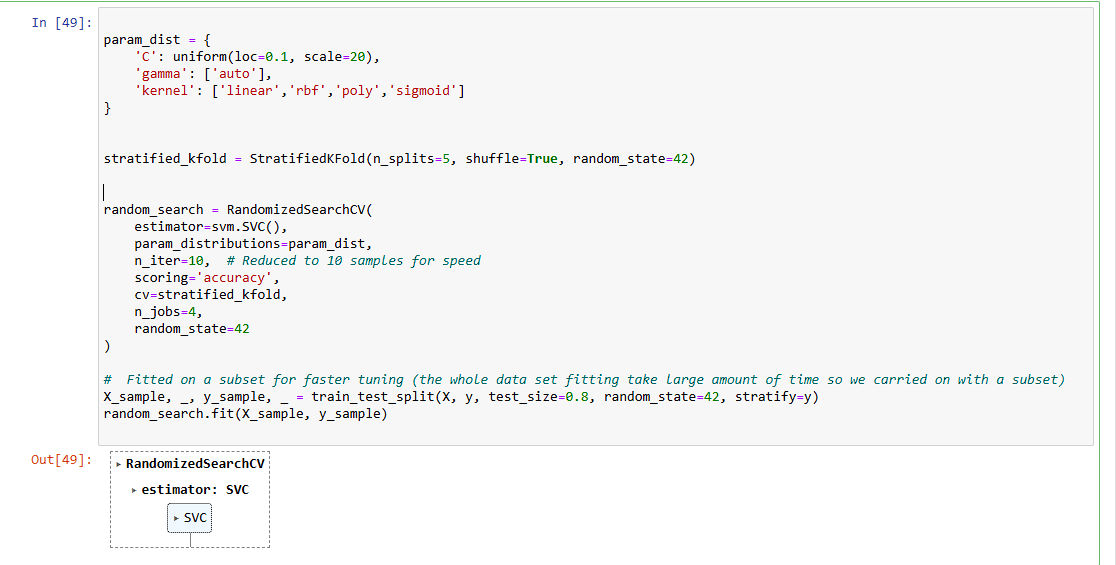

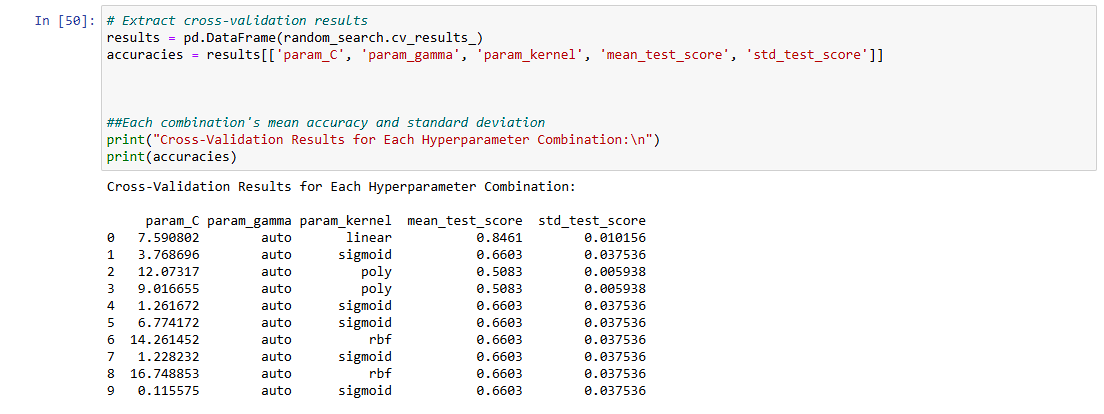

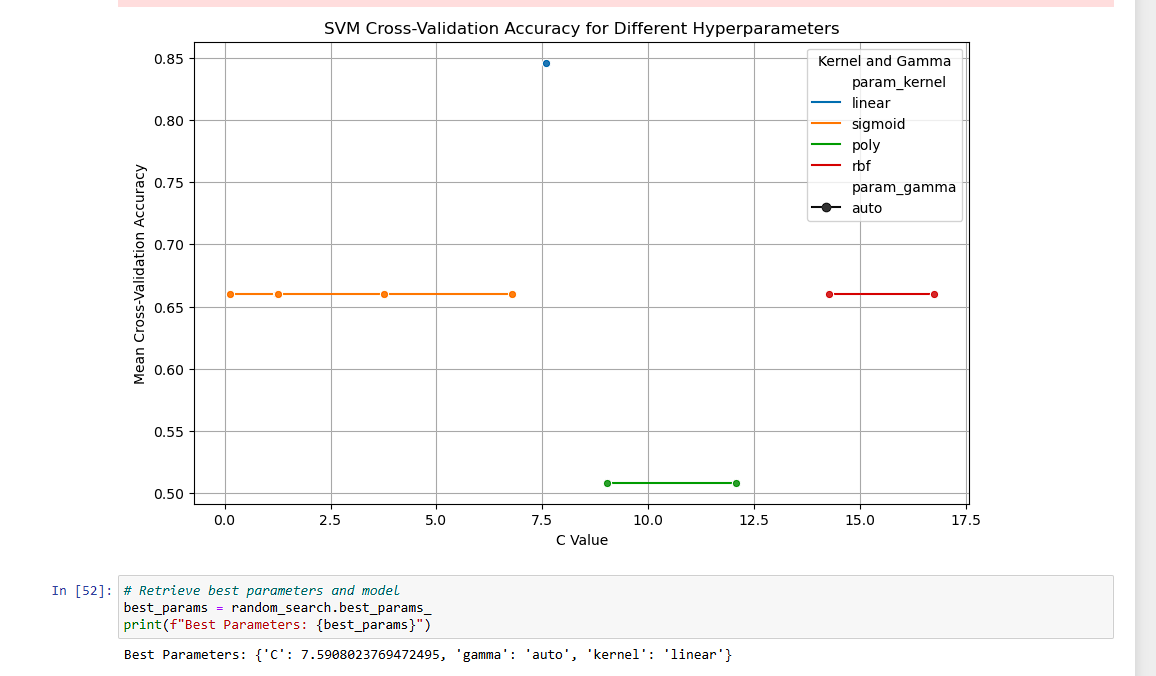

#### We then tried for the entire dataset and initialised RandomsearchCV and reduced our scale to 10 in the parameters for C cause its taking very long

In [56]:
# Defining a narrower parameter grid for SVM
param_dist = {
    'C': uniform(loc=0.1, scale=10),  # Narrowed range for faster tuning
    'gamma': ['auto'],
    'kernel': ['linear','rbf','poly','sigmoid']  
}

# Stratified K-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search with Stratified Cross-Validation
random_search = RandomizedSearchCV(
    estimator=svm.SVC(),
    param_distributions=param_dist,
    n_iter=10,  # Reduced to 10 samples for speed
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=4,
    random_state=42
)

# Optional: Fit on a subset for faster tuning
random_search.fit(X, y)


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_jobs=4,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A7C8EA2010>,
                                        'gamma': ['auto'],
                                        'kernel': ['linear', 'rbf', 'poly',
                                                   'sigmoid']},
                   random_state=42, scoring='accuracy')

In [ ]:
# Extract cross-validation results
results = pd.DataFrame(random_search.cv_results_)
accuracies = results[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'std_test_score']]

##Each combination's mean accuracy and standard deviation
print("Cross-Validation Results for Each Hyperparameter Combination:\n")
print(accuracies)

Cross-Validation Results for Each Hyperparameter Combination:

    param_C param_gamma param_kernel  mean_test_score  std_test_score
0  3.845401        auto       linear          0.88824        0.002959
1  1.934348        auto      sigmoid          0.66792        0.021093
2  6.086585        auto         poly          0.50316        0.000665
3  4.558328        auto         poly          0.50316        0.000665
4  0.680836        auto      sigmoid          0.66792        0.021093
5  3.437086        auto      sigmoid          0.66792        0.021093
6  7.180726        auto          rbf          0.66792        0.021093
7  0.664116        auto      sigmoid          0.66792        0.021093
8  8.424426        auto          rbf          0.66792        0.021093
9  0.107788        auto      sigmoid          0.66792        0.021093


C:\Users\Chethan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Chethan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


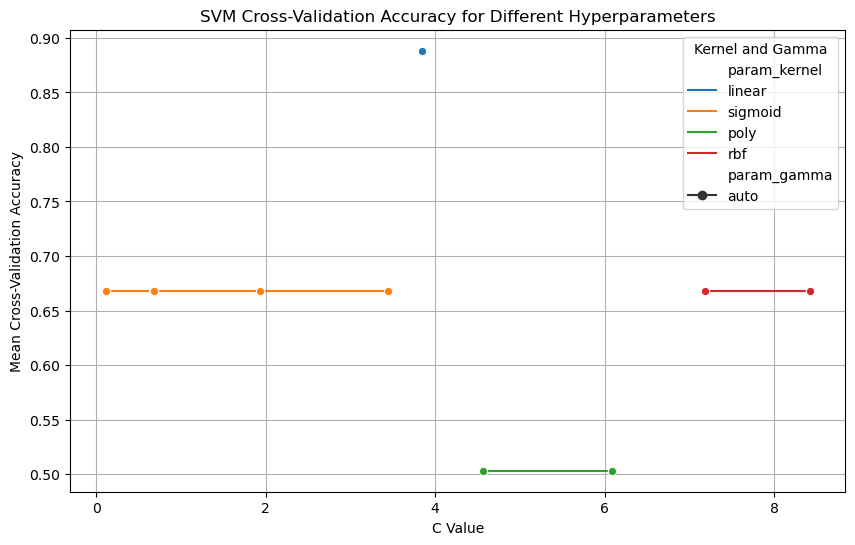

In [58]:
# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies, x='param_C', y='mean_test_score', hue='param_kernel', style='param_gamma', markers=True)
plt.title("SVM Cross-Validation Accuracy for Different Hyperparameters")
plt.xlabel("C Value")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.legend(title="Kernel and Gamma")
plt.grid(True)
plt.show()

In [59]:
# Retrieve best parameters and model
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")

Best Parameters: {'C': 3.845401188473625, 'gamma': 'auto', 'kernel': 'linear'}


#### From above so we can see that in the most cases linear has better accuracy than other kernels. So let's go with linear kernel and find the best parameter (C) for linear kernel 

In [ ]:
# parameter grid for SVM
param_dist = {
    'C': uniform(loc=0.1, scale=10),  # Narrowed range for faster tuning
    'gamma': ['auto'],
    'kernel': ['linear']  # Only 'linear' kernel cause rbf poly on 50000 data samples is taking very long and has very low scores
}

# Stratified K-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Randomized Search with Stratified Cross-Validation
random_search = RandomizedSearchCV(
    estimator=svm.SVC(),
    param_distributions=param_dist,
    n_iter=15,  # Reduced to 10 samples for speed
    scoring='accuracy',
    cv=stratified_kfold,
    n_jobs=5,
    random_state=42
)

random_search.fit(X, y)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SVC(), n_iter=15, n_jobs=5,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000002085EBD5C10>,
                                        'gamma': ['auto'],
                                        'kernel': ['linear']},
                   random_state=42, scoring='accuracy')

In [ ]:
# Extract cross-validation results
results = pd.DataFrame(random_search.cv_results_)
accuracies = results[['param_C', 'param_gamma', 'param_kernel', 'mean_test_score', 'std_test_score']]

# Each combination's mean accuracy and standard deviation
print("Cross-Validation Results for Each Hyperparameter Combination:\n")
print(accuracies)

Cross-Validation Results for Each Hyperparameter Combination:

     param_C param_gamma param_kernel  mean_test_score  std_test_score
0   3.845401        auto       linear          0.88824        0.002959
1   9.607143        auto       linear          0.87774        0.002953
2   7.419939        auto       linear          0.88122        0.003262
3   6.086585        auto       linear          0.88356        0.002880
4   1.660186        auto       linear          0.89512        0.002704
5   1.659945        auto       linear          0.89508        0.002656
6   0.680836        auto       linear          0.89814        0.002110
7   8.761761        auto       linear          0.87824        0.002842
8    6.11115        auto       linear          0.88352        0.002959
9   7.180726        auto       linear          0.88126        0.003248
10  0.305845        auto       linear          0.89674        0.002066
11  9.799099        auto       linear          0.87740        0.002952
12  8.424426  

C:\Users\Chethan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Chethan\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


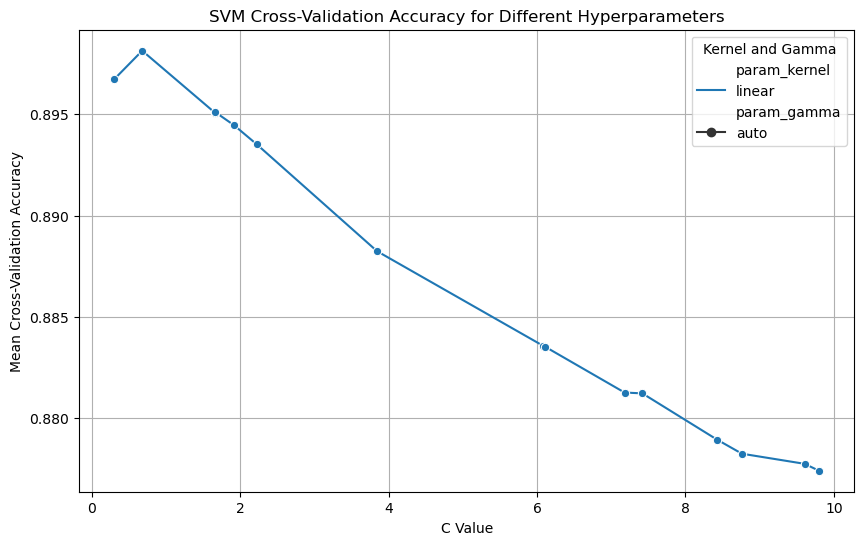

In [20]:
# Plotting the results
plt.figure(figsize=(10, 6))
sns.lineplot(data=accuracies, x='param_C', y='mean_test_score', hue='param_kernel', style='param_gamma', markers=True)
plt.title("SVM Cross-Validation Accuracy for Different Hyperparameters")
plt.xlabel("C Value")
plt.ylabel("Mean Cross-Validation Accuracy")
plt.legend(title="Kernel and Gamma")
plt.grid(True)
plt.show()

In [ ]:
# Retrieve best parameters and model
best_params = random_search.best_params_
print(f"Best Parameters: {best_params}")# Retrieve best parameters and model

Best Parameters: {'C': 0.6808361216819946, 'gamma': 'auto', 'kernel': 'linear'}


#### C = 0.6808361216819946, gamma = auto, kernal = linear, mean_test_score: 0.89814, std_test_score=0.002110

In [23]:
best_svm_model = random_search.best_estimator_

In [25]:
import pickle

In [26]:
# Saving the best model
pickle.dump(best_svm_model, open('svm_model.pkl', 'wb'))

In [27]:
# Final evaluation on a custom test set if desired
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
y_pred = best_svm_model.predict(X_test)

In [28]:
# Model Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

    Negative       0.94      0.93      0.93      4961
    Positive       0.93      0.94      0.94      5039

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000

Accuracy: 93.43%


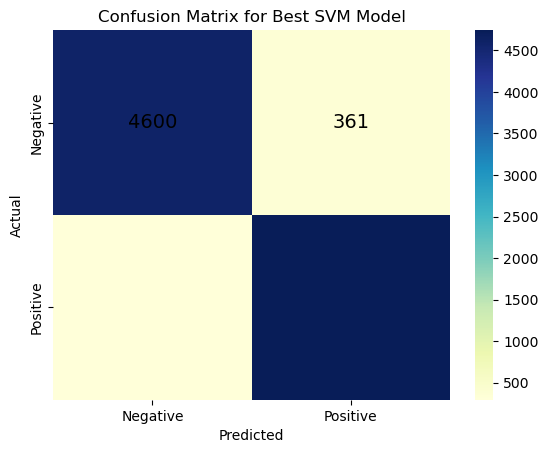

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'],
            annot_kws={"size": 14, "color": "black"})  # Larger font size, bold, and black text
plt.title('Confusion Matrix for Best SVM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Due to conflicts with environment of the device, complete labels on confusion matrix 
## could not be rendered. So we manually calculated the counts from precision and recall 
## and edited them in the report


In [ ]:
# Taking custom input
message = input()

# Data preprocessing and vectorization
message = lemmatize_data(clean_data(message))
message = vec.transform([message])

# Displaying prediction
pred = best_svm_model.predict(message)

match pred:
    case 0:
        print('negative')
    case 1:
        print('positive')